In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import scipy
import pandas as pd
import seaborn as sns

import cv2
import skvideo.io
import imageio
import pytube

import os
import time
import csv
import re
import humanize
from tqdm import tqdm

from skimage.measure import compare_mse, compare_ssim, compare_nrmse
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import hamming
from imageai.Detection import ObjectDetection
from imageai.Detection import VideoObjectDetection

In [4]:
import multiprocessing as mp

In [5]:
from PIL import Image, ImageChops

In [6]:
import platform

def print_sysinfo():

    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())

    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

print_sysinfo()


Python version  : 3.6.5
compiler        : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)

system     : Linux
release    : 3.10.0-862.3.2.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU count  : 16
interpreter: 64bit





# Data

In [3]:
save_path = './data'
video_url = 'https://www.youtube.com/watch?time_continue=218&v=FcAbi_mutTA'
pytube.YouTube(video_url).streams.first().download(save_path)

In [4]:
def video_to_image2(video_loc, img_folder, dataset_type, start_idx=0, end_idx=100000, img_quality=90):
    raw = {}
    
    cap = cv2.VideoCapture(video_loc)
    idx = 0
    ret = True
    while ret:
        ret, frame = cap.read()
        if idx > start_idx:
            img_path = os.path.join(img_folder, str(idx)+'.jpg')
            raw[idx] = [img_path, idx]
            #frame = cv2.flip(frame, -1)
            cv2.imwrite(img_path, frame, [cv2.IMWRITE_JPEG_QUALITY, img_quality])
        idx += 1
        if idx == end_idx:
            break
    cap.release()
    
    print('Done with %d frames' % (end_idx - start_idx - 1))
    print('Start index: ', start_idx)
    print('End index: ', end_idx)
    
    raw_df = pd.DataFrame.from_dict(raw, orient='index')
    raw_df.columns = ['img_path', 'img_index']
    raw_df.to_csv(os.path.join(data_path, dataset_type+'_raw.csv'), index=False)

In [5]:
save_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'
data_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'
result_path = '/home/idies/workspace/Storage/Cong/persistent/video/result'

In [6]:
train_video = os.path.join(data_path, 'speed-challenge-test.webm')
train_imgs = os.path.join(data_path, 'imgs-speed-challenge-test')

In [7]:
video_to_image2(train_video, train_imgs, 'train-speed-challenge-test', 0, 100000, 100)

Done with 99999 frames
Start index:  0
End index:  100000


In [8]:
train_df = pd.read_csv(os.path.join(data_path, 'train-speed-challenge-test_raw.csv'))
train_df.shape

(8616, 2)

Shape:  (360, 480, 3)


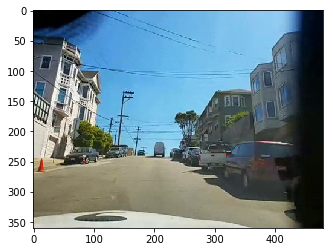

In [16]:
img = imread(train_df['img_path'][1000])
print('Shape: ', img.shape)
imshow(img);

# Preprocessing

In [4]:
def image_crop(h1, h2, l1, l2, original):
    return original[h1:h2, l1:l2, :]

In [5]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [5]:
def add_mask(img, coordinates):
    mask = np.zeros(img.shape, dtype = 'uint8')
    
    for coord in coordinates:
        cv2.rectangle(mask, coord[0], coord[1], (255, 255, 255), -1);
        
    maskedImg = cv2.bitwise_and(img, mask)
    return maskedImg

In [48]:
def detect_object(img, model='resnet50_coco_best_v2.0.1.h5', minimum_prob=80):
    detector = ObjectDetection()
    detector.setModelTypeAsRetinaNet()
    detector.setModelPath(os.path.join('/home/idies/workspace/Storage/Cong/persistent/video', model))
    detector.loadModel()
    detections = detector.detectObjectsFromImage(input_image=img, input_type='array', minimum_percentage_probability=minimum_prob)
    return detections

In [14]:
bright_factor = 0.2 + np.random.uniform()
bright_factor

1.0426016233980548

In [49]:
train_df = pd.read_csv(os.path.join(data_path, 'train101158_raw.csv'))
train_df.shape

(41499, 2)

Shape:  (1080, 1920, 3)


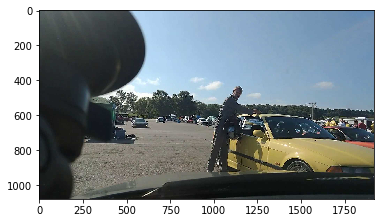

In [68]:
img = imread(train_df['img_path'][38500])
print('Shape: ', img.shape)
imshow(img);

In [69]:
detect_object(img)

[{'name': 'car',
  'percentage_probability': 86.01215481758118,
  'box_points': array([533, 620, 632, 677])},
 {'name': 'person',
  'percentage_probability': 94.65628862380981,
  'box_points': array([ 953,  400, 1276,  901])},
 {'name': 'car',
  'percentage_probability': 88.53282332420349,
  'box_points': array([ 994,  564, 1906,  915])}]

In [94]:
files = os.listdir('./data/objectcoords101158')
allobjectcoords = {}

In [95]:
for file in files:
    if len(re.findall('.npy', file)) > 0 and file != 'objectcoords820.npy':
        temp = np.load(os.path.join('./data/objectcoords101158', file))
        for i in range(len(temp)):
            allobjectcoords.update(temp[i])

In [96]:
temp = np.load(os.path.join('./data/objectcoords101158', 'objectcoords820.npy'))
allobjectcoords.update(temp.item())

In [97]:
allobjectcoords = dict(sorted(allobjectcoords.items()))

In [98]:
len(allobjectcoords)

41499

In [99]:
np.save('./data/objectcoords101158/allobjectcoords.npy', allobjectcoords)

In [15]:
files = os.listdir('./data/objectcoords101158')
partobjectcoords = {}

In [16]:
for file in files:
    if len(re.findall('.npy', file)) > 0:
        temp = np.load(os.path.join('./data/objectcoords101158', file))
        for i in range(len(temp)):
            partobjectcoords.update(temp[i])

In [9]:
files = os.listdir('./data/objectcoords101158')
for file in files:
    if len(re.findall('.npy', file)) > 0:
        temp = np.load(os.path.join('./data/objectcoords101158', file))
        for i in range(len(temp)):
            partobjectcoords.update(temp[i])

In [10]:
partobjectcoords = dict(sorted(partobjectcoords.items()))

In [11]:
len(partobjectcoords)

5000

In [12]:
np.save('./data/objectcoords101158/partobjectcoords.npy', partobjectcoords)

In [6]:
train_df = pd.read_csv(os.path.join(data_path, 'train101158_raw.csv'))
train_df.shape

(41499, 2)

In [7]:
partobjectcoords = np.load('./result/partobjectcoords.npy').item()

Shape:  (1080, 1920, 3)


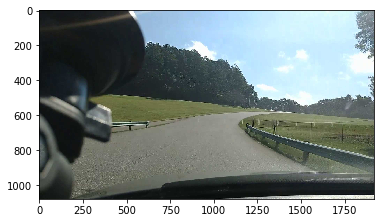

In [16]:
idx = 40999
img = imread(train_df['img_path'][idx])
coords = partobjectcoords[idx][2]
for i in range(len(coords)):
    coord = coords[i].get('box_points')
    cv2.rectangle(img, (coord[0],coord[1]), (coord[2],coord[3]), (255,0,0), 15);
    text = coords[i].get('name') + ': ' + str(round(coords[i].get('percentage_probability'),2)) + '%'
    x = int((coord[0]+coord[2])/2) - 100
    y = coord[1] - 50
    cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255,0,0), 10);
print('Shape: ', img.shape)
imshow(img);

In [17]:
def image_to_video(img_df, start, end, height, width, fps, objectcoords):
    
    video = cv2.VideoWriter('/home/idies/workspace/Temporary/Cong/scratch/video.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (width,height))
    cols = {'car': (0,0,255), 'person': (255,0,0), 'truck': (0,255,0), 'bicycle': (0,128,255), 'stop sign': (0,255,255), 'bench': (0,51,102)}
    
    for idx in range(start, end+1):
        img = cv2.imread(img_df['img_path'][idx])
        coords = objectcoords[idx][2]
        for i in range(len(coords)):
            coord = coords[i].get('box_points')
            if coords[i].get('name') in cols:
                col = cols.get(coords[i].get('name'))
            else:
                col = (0,0,0) 
            cv2.rectangle(img, (coord[0],coord[1]), (coord[2],coord[3]), col, 15);
            text = coords[i].get('name') + ': ' + str(round(coords[i].get('percentage_probability'),2)) + '%'
            x = int((coord[0]+coord[2])/2) - 100
            y = coord[1] - 50
            cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 2.5, col, 10);
        video.write(img);
        
    video.release()

In [19]:
img_df = pd.read_csv(os.path.join(data_path, 'train101158_raw.csv'))
start = 36000
end = 40999
height = 1080
width = 1920
fps = 30
objectcoords = np.load('./result/partobjectcoords.npy').item()
image_to_video(img_df, start, end, height, width, fps, objectcoords)

# Video Analysis

In [20]:
def get_FPS(video_loc):
    video = cv2.VideoCapture(video_loc)
    fps = video.get(cv2.CAP_PROP_FPS)
    return fps

In [21]:
train_video = os.path.join(data_path, 'speed-challenge-test.webm')

In [22]:
get_FPS(train_video)

25.0

In [19]:
model = 'resnet50_coco_best_v2.0.1.h5'
detector = VideoObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath(os.path.join('/home/idies/workspace/Storage/Cong/persistent/video', model))
detector.loadModel()

In [29]:
model = 'yolo-tiny.h5'
detector = VideoObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(os.path.join('/home/idies/workspace/Storage/Cong/persistent/video', model))
detector.loadModel()

In [30]:
video_path = detector.detectObjectsFromVideo(input_file_path=train_video,
                                             output_file_path='/home/idies/workspace/Temporary/Cong/scratch/detected', 
                                             frames_per_second=25, log_progress=True)

Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  

Processing Frame :  347
Processing Frame :  348
Processing Frame :  349
Processing Frame :  350
Processing Frame :  351
Processing Frame :  352
Processing Frame :  353
Processing Frame :  354
Processing Frame :  355
Processing Frame :  356
Processing Frame :  357
Processing Frame :  358
Processing Frame :  359
Processing Frame :  360
Processing Frame :  361
Processing Frame :  362
Processing Frame :  363
Processing Frame :  364
Processing Frame :  365
Processing Frame :  366
Processing Frame :  367
Processing Frame :  368
Processing Frame :  369
Processing Frame :  370
Processing Frame :  371
Processing Frame :  372
Processing Frame :  373
Processing Frame :  374
Processing Frame :  375
Processing Frame :  376
Processing Frame :  377
Processing Frame :  378
Processing Frame :  379
Processing Frame :  380
Processing Frame :  381
Processing Frame :  382
Processing Frame :  383
Processing Frame :  384
Processing Frame :  385
Processing Frame :  386
Processing Frame :  387
Processing Frame

Processing Frame :  689
Processing Frame :  690
Processing Frame :  691
Processing Frame :  692
Processing Frame :  693
Processing Frame :  694
Processing Frame :  695
Processing Frame :  696
Processing Frame :  697
Processing Frame :  698
Processing Frame :  699
Processing Frame :  700
Processing Frame :  701
Processing Frame :  702
Processing Frame :  703
Processing Frame :  704
Processing Frame :  705
Processing Frame :  706
Processing Frame :  707
Processing Frame :  708
Processing Frame :  709
Processing Frame :  710
Processing Frame :  711
Processing Frame :  712
Processing Frame :  713
Processing Frame :  714
Processing Frame :  715
Processing Frame :  716
Processing Frame :  717
Processing Frame :  718
Processing Frame :  719
Processing Frame :  720
Processing Frame :  721
Processing Frame :  722
Processing Frame :  723
Processing Frame :  724
Processing Frame :  725
Processing Frame :  726
Processing Frame :  727
Processing Frame :  728
Processing Frame :  729
Processing Frame

Processing Frame :  1030
Processing Frame :  1031
Processing Frame :  1032
Processing Frame :  1033
Processing Frame :  1034
Processing Frame :  1035
Processing Frame :  1036
Processing Frame :  1037
Processing Frame :  1038
Processing Frame :  1039
Processing Frame :  1040
Processing Frame :  1041
Processing Frame :  1042
Processing Frame :  1043
Processing Frame :  1044
Processing Frame :  1045
Processing Frame :  1046
Processing Frame :  1047
Processing Frame :  1048
Processing Frame :  1049
Processing Frame :  1050
Processing Frame :  1051
Processing Frame :  1052
Processing Frame :  1053
Processing Frame :  1054
Processing Frame :  1055
Processing Frame :  1056
Processing Frame :  1057
Processing Frame :  1058
Processing Frame :  1059
Processing Frame :  1060
Processing Frame :  1061
Processing Frame :  1062
Processing Frame :  1063
Processing Frame :  1064
Processing Frame :  1065
Processing Frame :  1066
Processing Frame :  1067
Processing Frame :  1068
Processing Frame :  1069


Processing Frame :  1358
Processing Frame :  1359
Processing Frame :  1360
Processing Frame :  1361
Processing Frame :  1362
Processing Frame :  1363
Processing Frame :  1364
Processing Frame :  1365
Processing Frame :  1366
Processing Frame :  1367
Processing Frame :  1368
Processing Frame :  1369
Processing Frame :  1370
Processing Frame :  1371
Processing Frame :  1372
Processing Frame :  1373
Processing Frame :  1374
Processing Frame :  1375
Processing Frame :  1376
Processing Frame :  1377
Processing Frame :  1378
Processing Frame :  1379
Processing Frame :  1380
Processing Frame :  1381
Processing Frame :  1382
Processing Frame :  1383
Processing Frame :  1384
Processing Frame :  1385
Processing Frame :  1386
Processing Frame :  1387
Processing Frame :  1388
Processing Frame :  1389
Processing Frame :  1390
Processing Frame :  1391
Processing Frame :  1392
Processing Frame :  1393
Processing Frame :  1394
Processing Frame :  1395
Processing Frame :  1396
Processing Frame :  1397


Processing Frame :  1686
Processing Frame :  1687
Processing Frame :  1688
Processing Frame :  1689
Processing Frame :  1690
Processing Frame :  1691
Processing Frame :  1692
Processing Frame :  1693
Processing Frame :  1694
Processing Frame :  1695
Processing Frame :  1696
Processing Frame :  1697
Processing Frame :  1698
Processing Frame :  1699
Processing Frame :  1700
Processing Frame :  1701
Processing Frame :  1702
Processing Frame :  1703
Processing Frame :  1704
Processing Frame :  1705
Processing Frame :  1706
Processing Frame :  1707
Processing Frame :  1708
Processing Frame :  1709
Processing Frame :  1710
Processing Frame :  1711
Processing Frame :  1712
Processing Frame :  1713
Processing Frame :  1714
Processing Frame :  1715
Processing Frame :  1716
Processing Frame :  1717
Processing Frame :  1718
Processing Frame :  1719
Processing Frame :  1720
Processing Frame :  1721
Processing Frame :  1722
Processing Frame :  1723
Processing Frame :  1724
Processing Frame :  1725


Processing Frame :  2014
Processing Frame :  2015
Processing Frame :  2016
Processing Frame :  2017
Processing Frame :  2018
Processing Frame :  2019
Processing Frame :  2020
Processing Frame :  2021
Processing Frame :  2022
Processing Frame :  2023
Processing Frame :  2024
Processing Frame :  2025
Processing Frame :  2026
Processing Frame :  2027
Processing Frame :  2028
Processing Frame :  2029
Processing Frame :  2030
Processing Frame :  2031
Processing Frame :  2032
Processing Frame :  2033
Processing Frame :  2034
Processing Frame :  2035
Processing Frame :  2036
Processing Frame :  2037
Processing Frame :  2038
Processing Frame :  2039
Processing Frame :  2040
Processing Frame :  2041
Processing Frame :  2042
Processing Frame :  2043
Processing Frame :  2044
Processing Frame :  2045
Processing Frame :  2046
Processing Frame :  2047
Processing Frame :  2048
Processing Frame :  2049
Processing Frame :  2050
Processing Frame :  2051
Processing Frame :  2052
Processing Frame :  2053


Processing Frame :  2342
Processing Frame :  2343
Processing Frame :  2344
Processing Frame :  2345
Processing Frame :  2346
Processing Frame :  2347
Processing Frame :  2348
Processing Frame :  2349
Processing Frame :  2350
Processing Frame :  2351
Processing Frame :  2352
Processing Frame :  2353
Processing Frame :  2354
Processing Frame :  2355
Processing Frame :  2356
Processing Frame :  2357
Processing Frame :  2358
Processing Frame :  2359
Processing Frame :  2360
Processing Frame :  2361
Processing Frame :  2362
Processing Frame :  2363
Processing Frame :  2364
Processing Frame :  2365
Processing Frame :  2366
Processing Frame :  2367
Processing Frame :  2368
Processing Frame :  2369
Processing Frame :  2370
Processing Frame :  2371
Processing Frame :  2372
Processing Frame :  2373
Processing Frame :  2374
Processing Frame :  2375
Processing Frame :  2376
Processing Frame :  2377
Processing Frame :  2378
Processing Frame :  2379
Processing Frame :  2380
Processing Frame :  2381


Processing Frame :  2670
Processing Frame :  2671
Processing Frame :  2672
Processing Frame :  2673
Processing Frame :  2674
Processing Frame :  2675
Processing Frame :  2676
Processing Frame :  2677
Processing Frame :  2678
Processing Frame :  2679
Processing Frame :  2680
Processing Frame :  2681
Processing Frame :  2682
Processing Frame :  2683
Processing Frame :  2684
Processing Frame :  2685
Processing Frame :  2686
Processing Frame :  2687
Processing Frame :  2688
Processing Frame :  2689
Processing Frame :  2690
Processing Frame :  2691
Processing Frame :  2692
Processing Frame :  2693
Processing Frame :  2694
Processing Frame :  2695
Processing Frame :  2696
Processing Frame :  2697
Processing Frame :  2698
Processing Frame :  2699
Processing Frame :  2700
Processing Frame :  2701
Processing Frame :  2702
Processing Frame :  2703
Processing Frame :  2704
Processing Frame :  2705
Processing Frame :  2706
Processing Frame :  2707
Processing Frame :  2708
Processing Frame :  2709


Processing Frame :  2998
Processing Frame :  2999
Processing Frame :  3000
Processing Frame :  3001
Processing Frame :  3002
Processing Frame :  3003
Processing Frame :  3004
Processing Frame :  3005
Processing Frame :  3006
Processing Frame :  3007
Processing Frame :  3008
Processing Frame :  3009
Processing Frame :  3010
Processing Frame :  3011
Processing Frame :  3012
Processing Frame :  3013
Processing Frame :  3014
Processing Frame :  3015
Processing Frame :  3016
Processing Frame :  3017
Processing Frame :  3018
Processing Frame :  3019
Processing Frame :  3020
Processing Frame :  3021
Processing Frame :  3022
Processing Frame :  3023
Processing Frame :  3024
Processing Frame :  3025
Processing Frame :  3026
Processing Frame :  3027
Processing Frame :  3028
Processing Frame :  3029
Processing Frame :  3030
Processing Frame :  3031
Processing Frame :  3032
Processing Frame :  3033
Processing Frame :  3034
Processing Frame :  3035
Processing Frame :  3036
Processing Frame :  3037


Processing Frame :  3326
Processing Frame :  3327
Processing Frame :  3328
Processing Frame :  3329
Processing Frame :  3330
Processing Frame :  3331
Processing Frame :  3332
Processing Frame :  3333
Processing Frame :  3334
Processing Frame :  3335
Processing Frame :  3336
Processing Frame :  3337
Processing Frame :  3338
Processing Frame :  3339
Processing Frame :  3340
Processing Frame :  3341
Processing Frame :  3342
Processing Frame :  3343
Processing Frame :  3344
Processing Frame :  3345
Processing Frame :  3346
Processing Frame :  3347
Processing Frame :  3348
Processing Frame :  3349
Processing Frame :  3350
Processing Frame :  3351
Processing Frame :  3352
Processing Frame :  3353
Processing Frame :  3354
Processing Frame :  3355
Processing Frame :  3356
Processing Frame :  3357
Processing Frame :  3358
Processing Frame :  3359
Processing Frame :  3360
Processing Frame :  3361
Processing Frame :  3362
Processing Frame :  3363
Processing Frame :  3364
Processing Frame :  3365


Processing Frame :  3654
Processing Frame :  3655
Processing Frame :  3656
Processing Frame :  3657
Processing Frame :  3658
Processing Frame :  3659
Processing Frame :  3660
Processing Frame :  3661
Processing Frame :  3662
Processing Frame :  3663
Processing Frame :  3664
Processing Frame :  3665
Processing Frame :  3666
Processing Frame :  3667
Processing Frame :  3668
Processing Frame :  3669
Processing Frame :  3670
Processing Frame :  3671
Processing Frame :  3672
Processing Frame :  3673
Processing Frame :  3674
Processing Frame :  3675
Processing Frame :  3676
Processing Frame :  3677
Processing Frame :  3678
Processing Frame :  3679
Processing Frame :  3680
Processing Frame :  3681
Processing Frame :  3682
Processing Frame :  3683
Processing Frame :  3684
Processing Frame :  3685
Processing Frame :  3686
Processing Frame :  3687
Processing Frame :  3688
Processing Frame :  3689
Processing Frame :  3690
Processing Frame :  3691
Processing Frame :  3692
Processing Frame :  3693


Processing Frame :  3982
Processing Frame :  3983
Processing Frame :  3984
Processing Frame :  3985
Processing Frame :  3986
Processing Frame :  3987
Processing Frame :  3988
Processing Frame :  3989
Processing Frame :  3990
Processing Frame :  3991
Processing Frame :  3992
Processing Frame :  3993
Processing Frame :  3994
Processing Frame :  3995
Processing Frame :  3996
Processing Frame :  3997
Processing Frame :  3998
Processing Frame :  3999
Processing Frame :  4000
Processing Frame :  4001
Processing Frame :  4002
Processing Frame :  4003
Processing Frame :  4004
Processing Frame :  4005
Processing Frame :  4006
Processing Frame :  4007
Processing Frame :  4008
Processing Frame :  4009
Processing Frame :  4010
Processing Frame :  4011
Processing Frame :  4012
Processing Frame :  4013
Processing Frame :  4014
Processing Frame :  4015
Processing Frame :  4016
Processing Frame :  4017
Processing Frame :  4018
Processing Frame :  4019
Processing Frame :  4020
Processing Frame :  4021


Processing Frame :  4310
Processing Frame :  4311
Processing Frame :  4312
Processing Frame :  4313
Processing Frame :  4314
Processing Frame :  4315
Processing Frame :  4316
Processing Frame :  4317
Processing Frame :  4318
Processing Frame :  4319
Processing Frame :  4320
Processing Frame :  4321
Processing Frame :  4322
Processing Frame :  4323
Processing Frame :  4324
Processing Frame :  4325
Processing Frame :  4326
Processing Frame :  4327
Processing Frame :  4328
Processing Frame :  4329
Processing Frame :  4330
Processing Frame :  4331
Processing Frame :  4332
Processing Frame :  4333
Processing Frame :  4334
Processing Frame :  4335
Processing Frame :  4336
Processing Frame :  4337
Processing Frame :  4338
Processing Frame :  4339
Processing Frame :  4340
Processing Frame :  4341
Processing Frame :  4342
Processing Frame :  4343
Processing Frame :  4344
Processing Frame :  4345
Processing Frame :  4346
Processing Frame :  4347
Processing Frame :  4348
Processing Frame :  4349


Processing Frame :  4638
Processing Frame :  4639
Processing Frame :  4640
Processing Frame :  4641
Processing Frame :  4642
Processing Frame :  4643
Processing Frame :  4644
Processing Frame :  4645
Processing Frame :  4646
Processing Frame :  4647
Processing Frame :  4648
Processing Frame :  4649
Processing Frame :  4650
Processing Frame :  4651
Processing Frame :  4652
Processing Frame :  4653
Processing Frame :  4654
Processing Frame :  4655
Processing Frame :  4656
Processing Frame :  4657
Processing Frame :  4658
Processing Frame :  4659
Processing Frame :  4660
Processing Frame :  4661
Processing Frame :  4662
Processing Frame :  4663
Processing Frame :  4664
Processing Frame :  4665
Processing Frame :  4666
Processing Frame :  4667
Processing Frame :  4668
Processing Frame :  4669
Processing Frame :  4670
Processing Frame :  4671
Processing Frame :  4672
Processing Frame :  4673
Processing Frame :  4674
Processing Frame :  4675
Processing Frame :  4676
Processing Frame :  4677


Processing Frame :  4966
Processing Frame :  4967
Processing Frame :  4968
Processing Frame :  4969
Processing Frame :  4970
Processing Frame :  4971
Processing Frame :  4972
Processing Frame :  4973
Processing Frame :  4974
Processing Frame :  4975
Processing Frame :  4976
Processing Frame :  4977
Processing Frame :  4978
Processing Frame :  4979
Processing Frame :  4980
Processing Frame :  4981
Processing Frame :  4982
Processing Frame :  4983
Processing Frame :  4984
Processing Frame :  4985
Processing Frame :  4986
Processing Frame :  4987
Processing Frame :  4988
Processing Frame :  4989
Processing Frame :  4990
Processing Frame :  4991
Processing Frame :  4992
Processing Frame :  4993
Processing Frame :  4994
Processing Frame :  4995
Processing Frame :  4996
Processing Frame :  4997
Processing Frame :  4998
Processing Frame :  4999
Processing Frame :  5000
Processing Frame :  5001
Processing Frame :  5002
Processing Frame :  5003
Processing Frame :  5004
Processing Frame :  5005


Processing Frame :  5294
Processing Frame :  5295
Processing Frame :  5296
Processing Frame :  5297
Processing Frame :  5298
Processing Frame :  5299
Processing Frame :  5300
Processing Frame :  5301
Processing Frame :  5302
Processing Frame :  5303
Processing Frame :  5304
Processing Frame :  5305
Processing Frame :  5306
Processing Frame :  5307
Processing Frame :  5308
Processing Frame :  5309
Processing Frame :  5310
Processing Frame :  5311
Processing Frame :  5312
Processing Frame :  5313
Processing Frame :  5314
Processing Frame :  5315
Processing Frame :  5316
Processing Frame :  5317
Processing Frame :  5318
Processing Frame :  5319
Processing Frame :  5320
Processing Frame :  5321
Processing Frame :  5322
Processing Frame :  5323
Processing Frame :  5324
Processing Frame :  5325
Processing Frame :  5326
Processing Frame :  5327
Processing Frame :  5328
Processing Frame :  5329
Processing Frame :  5330
Processing Frame :  5331
Processing Frame :  5332
Processing Frame :  5333


Processing Frame :  5622
Processing Frame :  5623
Processing Frame :  5624
Processing Frame :  5625
Processing Frame :  5626
Processing Frame :  5627
Processing Frame :  5628
Processing Frame :  5629
Processing Frame :  5630
Processing Frame :  5631
Processing Frame :  5632
Processing Frame :  5633
Processing Frame :  5634
Processing Frame :  5635
Processing Frame :  5636
Processing Frame :  5637
Processing Frame :  5638
Processing Frame :  5639
Processing Frame :  5640
Processing Frame :  5641
Processing Frame :  5642
Processing Frame :  5643
Processing Frame :  5644
Processing Frame :  5645
Processing Frame :  5646
Processing Frame :  5647
Processing Frame :  5648
Processing Frame :  5649
Processing Frame :  5650
Processing Frame :  5651
Processing Frame :  5652
Processing Frame :  5653
Processing Frame :  5654
Processing Frame :  5655
Processing Frame :  5656
Processing Frame :  5657
Processing Frame :  5658
Processing Frame :  5659
Processing Frame :  5660
Processing Frame :  5661


Processing Frame :  5950
Processing Frame :  5951
Processing Frame :  5952
Processing Frame :  5953
Processing Frame :  5954
Processing Frame :  5955
Processing Frame :  5956
Processing Frame :  5957
Processing Frame :  5958
Processing Frame :  5959
Processing Frame :  5960
Processing Frame :  5961
Processing Frame :  5962
Processing Frame :  5963
Processing Frame :  5964
Processing Frame :  5965
Processing Frame :  5966
Processing Frame :  5967
Processing Frame :  5968
Processing Frame :  5969
Processing Frame :  5970
Processing Frame :  5971
Processing Frame :  5972
Processing Frame :  5973
Processing Frame :  5974
Processing Frame :  5975
Processing Frame :  5976
Processing Frame :  5977
Processing Frame :  5978
Processing Frame :  5979
Processing Frame :  5980
Processing Frame :  5981
Processing Frame :  5982
Processing Frame :  5983
Processing Frame :  5984
Processing Frame :  5985
Processing Frame :  5986
Processing Frame :  5987
Processing Frame :  5988
Processing Frame :  5989


Processing Frame :  6278
Processing Frame :  6279
Processing Frame :  6280
Processing Frame :  6281
Processing Frame :  6282
Processing Frame :  6283
Processing Frame :  6284
Processing Frame :  6285
Processing Frame :  6286
Processing Frame :  6287
Processing Frame :  6288
Processing Frame :  6289
Processing Frame :  6290
Processing Frame :  6291
Processing Frame :  6292
Processing Frame :  6293
Processing Frame :  6294
Processing Frame :  6295
Processing Frame :  6296
Processing Frame :  6297
Processing Frame :  6298
Processing Frame :  6299
Processing Frame :  6300
Processing Frame :  6301
Processing Frame :  6302
Processing Frame :  6303
Processing Frame :  6304
Processing Frame :  6305
Processing Frame :  6306
Processing Frame :  6307
Processing Frame :  6308
Processing Frame :  6309
Processing Frame :  6310
Processing Frame :  6311
Processing Frame :  6312
Processing Frame :  6313
Processing Frame :  6314
Processing Frame :  6315
Processing Frame :  6316
Processing Frame :  6317


Processing Frame :  6606
Processing Frame :  6607
Processing Frame :  6608
Processing Frame :  6609
Processing Frame :  6610
Processing Frame :  6611
Processing Frame :  6612
Processing Frame :  6613
Processing Frame :  6614
Processing Frame :  6615
Processing Frame :  6616
Processing Frame :  6617
Processing Frame :  6618
Processing Frame :  6619
Processing Frame :  6620
Processing Frame :  6621
Processing Frame :  6622
Processing Frame :  6623
Processing Frame :  6624
Processing Frame :  6625
Processing Frame :  6626
Processing Frame :  6627
Processing Frame :  6628
Processing Frame :  6629
Processing Frame :  6630
Processing Frame :  6631
Processing Frame :  6632
Processing Frame :  6633
Processing Frame :  6634
Processing Frame :  6635
Processing Frame :  6636
Processing Frame :  6637
Processing Frame :  6638
Processing Frame :  6639
Processing Frame :  6640
Processing Frame :  6641
Processing Frame :  6642
Processing Frame :  6643
Processing Frame :  6644
Processing Frame :  6645


Processing Frame :  6934
Processing Frame :  6935
Processing Frame :  6936
Processing Frame :  6937
Processing Frame :  6938
Processing Frame :  6939
Processing Frame :  6940
Processing Frame :  6941
Processing Frame :  6942
Processing Frame :  6943
Processing Frame :  6944
Processing Frame :  6945
Processing Frame :  6946
Processing Frame :  6947
Processing Frame :  6948
Processing Frame :  6949
Processing Frame :  6950
Processing Frame :  6951
Processing Frame :  6952
Processing Frame :  6953
Processing Frame :  6954
Processing Frame :  6955
Processing Frame :  6956
Processing Frame :  6957
Processing Frame :  6958
Processing Frame :  6959
Processing Frame :  6960
Processing Frame :  6961
Processing Frame :  6962
Processing Frame :  6963
Processing Frame :  6964
Processing Frame :  6965
Processing Frame :  6966
Processing Frame :  6967
Processing Frame :  6968
Processing Frame :  6969
Processing Frame :  6970
Processing Frame :  6971
Processing Frame :  6972
Processing Frame :  6973


Processing Frame :  7262
Processing Frame :  7263
Processing Frame :  7264
Processing Frame :  7265
Processing Frame :  7266
Processing Frame :  7267
Processing Frame :  7268
Processing Frame :  7269
Processing Frame :  7270
Processing Frame :  7271
Processing Frame :  7272
Processing Frame :  7273
Processing Frame :  7274
Processing Frame :  7275
Processing Frame :  7276
Processing Frame :  7277
Processing Frame :  7278
Processing Frame :  7279
Processing Frame :  7280
Processing Frame :  7281
Processing Frame :  7282
Processing Frame :  7283
Processing Frame :  7284
Processing Frame :  7285
Processing Frame :  7286
Processing Frame :  7287
Processing Frame :  7288
Processing Frame :  7289
Processing Frame :  7290
Processing Frame :  7291
Processing Frame :  7292
Processing Frame :  7293
Processing Frame :  7294
Processing Frame :  7295
Processing Frame :  7296
Processing Frame :  7297
Processing Frame :  7298
Processing Frame :  7299
Processing Frame :  7300
Processing Frame :  7301


Processing Frame :  7590
Processing Frame :  7591
Processing Frame :  7592
Processing Frame :  7593
Processing Frame :  7594
Processing Frame :  7595
Processing Frame :  7596
Processing Frame :  7597
Processing Frame :  7598
Processing Frame :  7599
Processing Frame :  7600
Processing Frame :  7601
Processing Frame :  7602
Processing Frame :  7603
Processing Frame :  7604
Processing Frame :  7605
Processing Frame :  7606
Processing Frame :  7607
Processing Frame :  7608
Processing Frame :  7609
Processing Frame :  7610
Processing Frame :  7611
Processing Frame :  7612
Processing Frame :  7613
Processing Frame :  7614
Processing Frame :  7615
Processing Frame :  7616
Processing Frame :  7617
Processing Frame :  7618
Processing Frame :  7619
Processing Frame :  7620
Processing Frame :  7621
Processing Frame :  7622
Processing Frame :  7623
Processing Frame :  7624
Processing Frame :  7625
Processing Frame :  7626
Processing Frame :  7627
Processing Frame :  7628
Processing Frame :  7629


Processing Frame :  7918
Processing Frame :  7919
Processing Frame :  7920
Processing Frame :  7921
Processing Frame :  7922
Processing Frame :  7923
Processing Frame :  7924
Processing Frame :  7925
Processing Frame :  7926
Processing Frame :  7927
Processing Frame :  7928
Processing Frame :  7929
Processing Frame :  7930
Processing Frame :  7931
Processing Frame :  7932
Processing Frame :  7933
Processing Frame :  7934
Processing Frame :  7935
Processing Frame :  7936
Processing Frame :  7937
Processing Frame :  7938
Processing Frame :  7939
Processing Frame :  7940
Processing Frame :  7941
Processing Frame :  7942
Processing Frame :  7943
Processing Frame :  7944
Processing Frame :  7945
Processing Frame :  7946
Processing Frame :  7947
Processing Frame :  7948
Processing Frame :  7949
Processing Frame :  7950
Processing Frame :  7951
Processing Frame :  7952
Processing Frame :  7953
Processing Frame :  7954
Processing Frame :  7955
Processing Frame :  7956
Processing Frame :  7957


Processing Frame :  8246
Processing Frame :  8247
Processing Frame :  8248
Processing Frame :  8249
Processing Frame :  8250
Processing Frame :  8251
Processing Frame :  8252
Processing Frame :  8253
Processing Frame :  8254
Processing Frame :  8255
Processing Frame :  8256
Processing Frame :  8257
Processing Frame :  8258
Processing Frame :  8259
Processing Frame :  8260
Processing Frame :  8261
Processing Frame :  8262
Processing Frame :  8263
Processing Frame :  8264
Processing Frame :  8265
Processing Frame :  8266
Processing Frame :  8267
Processing Frame :  8268
Processing Frame :  8269
Processing Frame :  8270
Processing Frame :  8271
Processing Frame :  8272
Processing Frame :  8273
Processing Frame :  8274
Processing Frame :  8275
Processing Frame :  8276
Processing Frame :  8277
Processing Frame :  8278
Processing Frame :  8279
Processing Frame :  8280
Processing Frame :  8281
Processing Frame :  8282
Processing Frame :  8283
Processing Frame :  8284
Processing Frame :  8285


Processing Frame :  8574
Processing Frame :  8575
Processing Frame :  8576
Processing Frame :  8577
Processing Frame :  8578
Processing Frame :  8579
Processing Frame :  8580
Processing Frame :  8581
Processing Frame :  8582
Processing Frame :  8583
Processing Frame :  8584
Processing Frame :  8585
Processing Frame :  8586
Processing Frame :  8587
Processing Frame :  8588
Processing Frame :  8589
Processing Frame :  8590
Processing Frame :  8591
Processing Frame :  8592
Processing Frame :  8593
Processing Frame :  8594
Processing Frame :  8595
Processing Frame :  8596
Processing Frame :  8597
Processing Frame :  8598
Processing Frame :  8599
Processing Frame :  8600
Processing Frame :  8601
Processing Frame :  8602
Processing Frame :  8603
Processing Frame :  8604
Processing Frame :  8605
Processing Frame :  8606
Processing Frame :  8607
Processing Frame :  8608
Processing Frame :  8609
Processing Frame :  8610
Processing Frame :  8611
Processing Frame :  8612
Processing Frame :  8613


In [ ]:
def forFrame(frame_number, output_array, output_count):
    results = {}
    results[frame_number] = [output_array, output_count]
    np.save(os.path.join(result_path, 'objects'+str(frame_number)+'.npy'), results)

In [31]:
files = os.listdir('./result/detected')
objects = {}

In [43]:
for i in range(len(files)):
    temp = np.load(os.path.join('./result/detected', files[i])).item()
    objects[i+1] = temp[i+1][1]

In [46]:
np.save('./result/objects.npy', objects)

In [47]:
dat = pd.DataFrame.from_dict(objects, orient='index')

In [52]:
dat.columns

Index(['car', 'truck', 'bus', 'person', 'stop sign', 'train', 'kite', 'tv',
       'horse', 'motorcycle', 'bicycle', 'traffic light', 'suitcase',
       'backpack', 'sink', 'broccoli', 'boat', 'potted plant', 'bird',
       'airplane', 'bench', 'bottle', 'cow', 'frisbee', 'umbrella'],
      dtype='object')

In [60]:
dat_dict = {}
objs = ['person', 'car', 'truck', 'bus', 'motorcycle', 'bicycle', 'stop sign', 'traffic light']

In [70]:
for i in range(len(objects)):
    dat_dict[i+1] = {'frame': i}
    for obj in objs:
        if objects[i+1].get(obj) is None:
            dat_dict[i+1][obj] = 0
        else:
            dat_dict[i+1][obj] = objects[i+1].get(obj)

In [73]:
dat_df = pd.DataFrame.from_dict(dat_dict, orient='index')

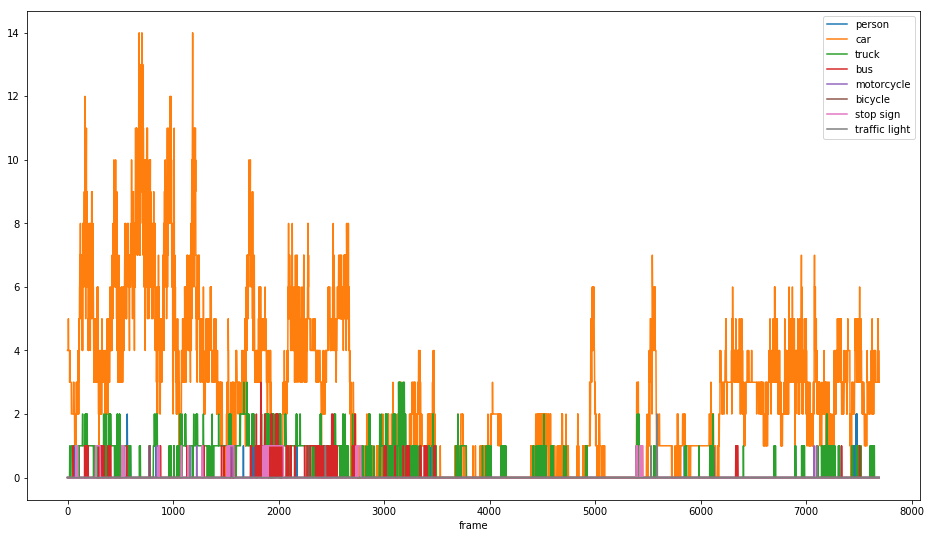

In [79]:
dat_df.set_index('frame').plot(figsize=(16,9));

In [83]:
dat_df.columns

Index(['frame', 'person', 'car', 'truck', 'bus', 'motorcycle', 'bicycle',
       'stop sign', 'traffic light'],
      dtype='object')

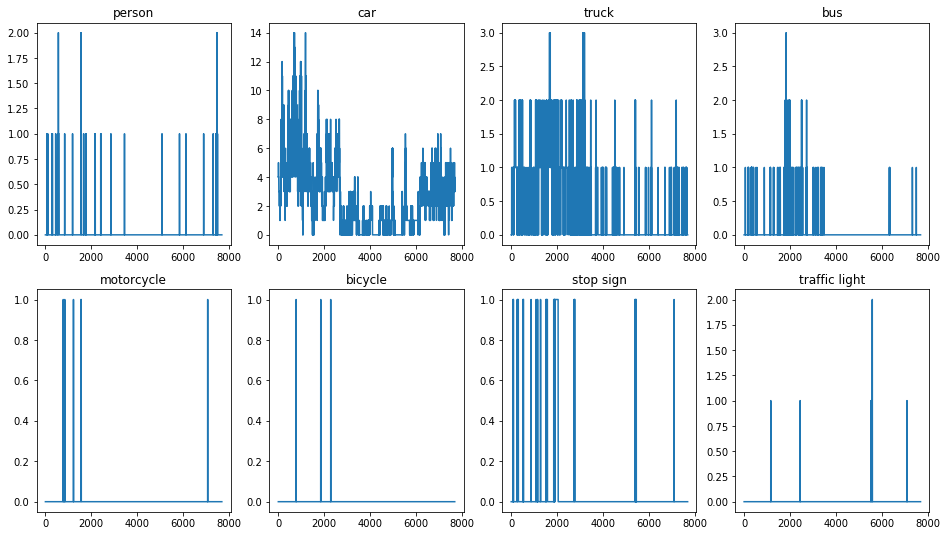

In [86]:
figure(figsize=(16,9));
subplot(2, 4, 1);
title('person');
plot(dat_df.frame, dat_df.person);
subplot(2, 4, 2);
title('car');
plot(dat_df.frame, dat_df.car);
subplot(2, 4, 3);
title('truck');
plot(dat_df.frame, dat_df.truck);
subplot(2, 4, 4);
title('bus');
plot(dat_df.frame, dat_df.bus);
subplot(2, 4, 5);
title('motorcycle');
plot(dat_df.frame, dat_df.motorcycle);
subplot(2, 4, 6);
title('bicycle');
plot(dat_df.frame, dat_df.bicycle);
subplot(2, 4, 7);
title('stop sign');
plot(dat_df.frame, dat_df['stop sign']);
subplot(2, 4, 8);
title('traffic light');
plot(dat_df.frame, dat_df['traffic light']);

In [106]:
dat_seconds_dict = {}

In [112]:
for i in range(1, 5000, 25):
    dat_seconds_dict[i] = {'person': np.mean(dat_df['person'][(i):(i+25)]), 
                           'car': np.mean(dat_df['car'][(i):(i+25)]), 
                           'truck': np.mean(dat_df['truck'][(i):(i+25)]), 
                           'bus': np.mean(dat_df['bus'][(i):(i+25)]), 
                           'motorcycle': np.mean(dat_df['motorcycle'][(i):(i+25)]), 
                           'bicycle': np.mean(dat_df['bicycle'][(i):(i+25)]), 
                           'stop sign': np.mean(dat_df['stop sign'][(i):(i+25)]), 
                           'traffic light': np.mean(dat_df['traffic light'][(i):(i+25)])}

In [113]:
dat_seconds_df = pd.DataFrame.from_dict(dat_seconds_dict, orient='index')
dat_seconds_df.index = np.arange(1, 201)

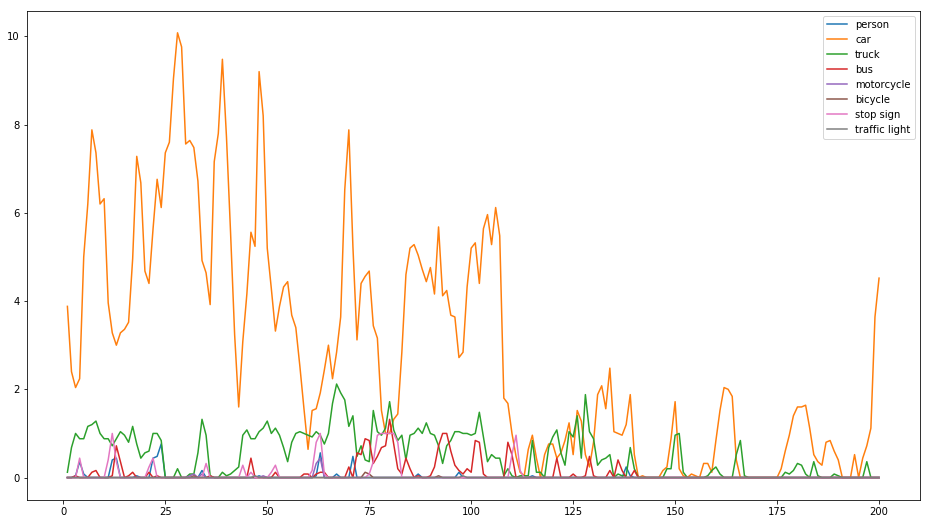

In [122]:
dat_seconds_df.plot(figsize=(16,9));